In [924]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from pytz import timezone, utc
from timezonefinder import TimezoneFinder

import geopy.distance
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)


# AIR TRAVEL (March 2015-)

In [925]:
# ROOT_DIR = '/Users/alexanderguo/Desktop/flightlog/'
ROOT_DIR = '/Users/alexanderguo/Google Drive/MIT/junior/sem2/picrazy2.github.io/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

In [926]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'Lat': 'Dep Lat', 'Long': 'Dep Long', 'City': 'Dep City', 'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'Lat': 'Arr Lat', 'Long': 'Arr Long', 'City': 'Arr City', 'Country': 'Arr Country'})

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1)
df['Duration'] = df.apply(lambda row: np.sum(np.multiply(np.array([int(x) for x in row['Actual Duration'].split(':')]), np.array([60, 1]))) if isinstance(row['Actual Duration'], str) else 0, axis=1)

important_cols = ['Date', 'Actual Dep Time (Local)', 'Actual Dep Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Class', 'Aircraft', 'Distance', 'Registration']

TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Duration'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))

Total Distance Flown (miles): 430181.60684678465
Total time in the air: 35 days, 4:15:00
Total Flights: 188
Number of Airlines: 28
Number of Countries: 25
Number of Airports: 69


# FLIGHTS SORTED BY DISTANCE

In [927]:
df.sort_values(['Distance'], ascending=False).head(50)[important_cols]
df.loc[df['Domestic/International']=='Domestic']

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Scheduled Duration,Actual Dep Time (Local),Actual Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Domestic/International,Class,Business Type,Layout,Seat,Aircraft,Registration,Arr Connect,Timing Data,Dep Name,Dep City,Dep Country,Dep Lat,Dep Long,Arr Name,Arr City,Arr Country,Arr Lat,Arr Long,Distance,Duration
0,2015-03-08,8:34,10:01,1:27,8:52,9:42,0:50,United,UA1711,BOS,EWR,Domestic,Business,Recliner,NaN,NaN,B738,N54241,1.0,FlightStats,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,200.540719,50
3,2015-03-19,20:32,21:46,1:14,21:21,22:03,0:42,United,UA1409,EWR,BOS,Domestic,Economy,NaN,NaN,NaN,B734,N87512,NaN,FlightStats,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,200.540719,42
4,2015-07-05,17:27,20:45,6:18,18:00,20:30,5:30,JetBlue,B6487,BOS,LAX,Domestic,Economy,NaN,NaN,20E,A320,N775JB,NaN,FlightStats,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,2611.132058,330
5,2015-08-01,11:35,20:05,5:30,12:10,19:59,4:49,JetBlue,B6488,LAX,BOS,Domestic,Economy,NaN,NaN,15E,A320,N590JB,NaN,FlightStats,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,2611.132058,289
6,2015-12-18,7:50,9:24,1:34,8:35,9:29,0:54,United,UA1928,BOS,EWR,Domestic,Business,Recliner,NaN,NaN,B733,N76503,1.0,FlightStats,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,200.540719,54
8,2015-12-20,NaN,NaN,NaN,NaN,NaN,3:50,NaN,NaN,PEK,SYX,Domestic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FlightStats,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,Sanya Phoenix International Airport,Sanya,China,18.302900,109.412003,1559.889917,230
9,2015-12-24,NaN,NaN,NaN,NaN,NaN,3:15,NaN,NaN,SYX,PEK,Domestic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FlightStats,Sanya Phoenix International Airport,Sanya,China,18.302900,109.412003,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,1559.889917,195
11,2016-01-02,22:25,23:58,1:33,22:32,23:36,1:04,United,UA352,IAD,BOS,Domestic,Economy,NaN,NaN,NaN,A320,N448UA,NaN,FlightStats,Washington Dulles International Airport,Washington,United States,38.944500,-77.455803,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,412.836191,64
13,2016-03-16,9:35,12:40,3:05,9:35,12:20,2:50,Hainan,HU7215,PEK,KWL,Domestic,Economy,NaN,NaN,NaN,B738,B5089,NaN,FlightStats,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,Guilin Liangjiang International Airport,Guilin,China,25.218100,110.039001,1092.079905,170
14,2016-03-19,10:20,12:05,1:45,10:35,12:03,1:28,China Southern,CZ6709,KWL,CTU,Domestic,Economy,NaN,NaN,NaN,A320,B1805,NaN,FlightStats,Guilin Liangjiang International Airport,Guilin,China,25.218100,110.039001,Chengdu Shuangliu International Airport,Chengdu,China,30.578501,103.946999,524.333358,88


# FLIGHTS SORTED BY DURATION

In [928]:
df.sort_values(['Duration'], ascending=False).head(50)[important_cols]

,Date,Actual Dep Time (Local),Actual Dep Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Class,Aircraft,Distance,Registration
71,2018-01-07,10:20,10:20,14:09,United,UA2,SIN,SFO,Business,B789,8446.305238,N38955
73,2018-03-22,16:49,16:49,14:03,Hainan,HU7962,BOS,PVG,Economy,B788,7307.683803,B2750
74,2018-03-29,12:51,12:51,14:03,Hainan,HU7961,PVG,BOS,Economy,B789,7307.683803,B7835
97,2019-01-06,1:09,1:09,13:50,Air Canada,AC57,DXB,YYZ,Business,B77W,6899.002047,CFRAM
125,2019-12-18,22:44,22:44,13:34,United,UA1122,EWR,CPT,Business,B789,7816.760114,N27957
1,2015-03-08,13:40,13:40,13:30,United,UA89,EWR,PEK,Economy,B772,6830.922824,N78005
20,2016-06-05,17:19,17:19,13:29,Hainan,HU482,BOS,PEK,Economy,B788,6736.622183,B2730
12,2016-03-13,16:58,16:58,13:26,Hainan,HU482,BOS,PEK,Business,B788,6736.622183,B2731
7,2015-12-18,12:19,12:19,13:22,United,UA89,EWR,PEK,Economy,B772,6830.922824,N78008
113,2019-08-17,12:03,12:03,13:17,United,UA89,EWR,PEK,Business,B772,6830.922824,N37018


# ALL COUNTRIES AND AIRPORTS

In [929]:
dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country', 'Airport', 'Departures']
arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'Airport', 'Arrivals']
countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']
countries.astype('int32')

Departures  Arrivals  Total Dep/Arr
Country               Airport                                     
Australia             BNE               1         1              2
                      SYD               1         1              2
Bahamas               NAS               1         1              2
Bermuda               BDA               1         1              2
Canada                YYZ               1         1              2
China                 CTU               1         1              2
                      DNH               1         1              2
                      HGH               1         1              2
                      HRB               1         1              2
                      KJI               1         1              2
                      KMG               1         1              2
                      KWL               1         1              2
                      LHW               1         1              2
                      LJG               1         1              2
                      PEK              23        25             48
                      PVG               2         2              4
                      SHA               1         0              1
                      SYX               1         1              2
                      SZX               1         0              1
                      URC               2         2              4
                      WUX               1         1              2
                      XIY               1         1              2
France                CDG               2         2              4
                      NCE               1         1              2
Germany               FRA               2         2              4
                      MUC               1         1              2
Iceland               KEF               1         1              2
Italy                 FCO               1         1              2
Japan                 HND               1         0              1
                      KIX               1         1              2
                      NRT               0         1              1
Malaysia              KUL               1         1              2
Mexico                PVR               1         1              2
Portugal              LIS               3         3              6
Puerto Rico           SJU               1         1              2
Saint Kitts and Nevis SKB               1         1              2
Singapore             SIN               2         2              4
South Africa          CPT               2         1              3
                      PLZ               0         1              1
South Korea           GMP               1         1              2
                      ICN               1         1              2
Spain                 BCN               1         1              2
                      MAD               0         1              1
                      VLL               1         0              1
Thailand              BKK               0         1              1
                      DMK               1         0              1
Turkey                IST               2         2              4
                      NAV               1         1              2
United Arab Emirates  DXB               2         2              4
United Kingdom        LHR               1         1              2
United States         ANC               1         1              2
                      BDL               1         1              2
                      BOS              37        36             73
                      DEN               6         6             12
                      DTW               2         2              4
                      EWR              26        26             52
                      HNL               1         1              2
                      IAD               7         7             14
           

# AIRPORTS SORTED BY TOTAL DEPARTURES PLUS ARRIVALS

In [930]:
countries_sorted = countries.sort_values(by=['Total Dep/Arr'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(10)

Departures  Arrivals  Total Dep/Arr
Country       Airport                                     
United States BOS              37        36             73
              EWR              26        26             52
China         PEK              23        25             48
United States SFO               9        10             19
              IAD               7         7             14
              DEN               6         6             12
              ORD               5         5             10
              LAX               4         4              8
              PHL               3         4              7
Portugal      LIS               3         3              6

<AxesSubplot:ylabel='Total Dep/Arr'>

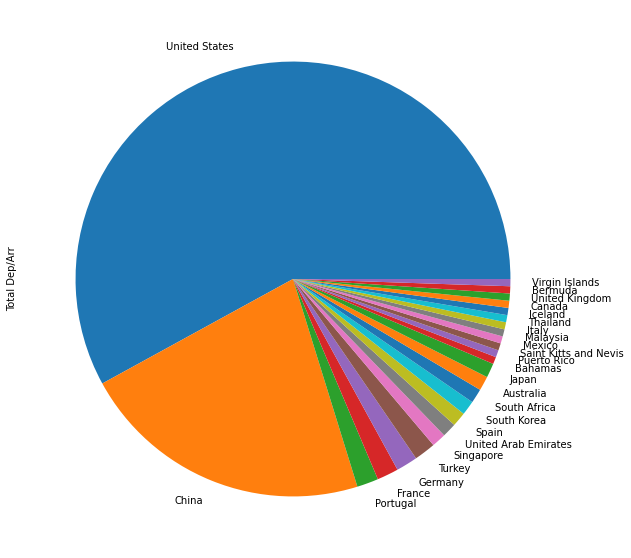

In [931]:
countries_sorted.reset_index().groupby('Country').agg({'Total Dep/Arr': sum}).sort_values(by='Total Dep/Arr', ascending=False).plot('Country', 'Total Dep/Arr', kind='pie', legend=False, figsize=(10, 10))

# TOP ROUTES

In [932]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(10)

Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             14     2807.570070
EWR         BOS             12     2406.488631
            PEK             10    68309.228239
SFO         BOS              6    16224.706890
PEK         EWR              5    34154.614120
BOS         ORD              3     2599.949013
IAD         BOS              3     1238.508572
PEK         IAD              3    20762.252704
BOS         IAD              3     1238.508572
PEK         SFO              2    11826.371186

In [933]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted.head(8)

,Count,Total Distance
Sorted Route,,
BOS EWR,26,5214.058701
EWR PEK,15,102463.842359
BOS SFO,8,21632.942519
BOS IAD,6,2477.017144
BOS DEN,4,7016.192200
BOS ORD,4,3466.598684
BOS PHL,3,840.060616
BOS PEK,3,20209.866549


# TOP AIRLINES

In [934]:
airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
airlines.columns = ['Count', 'Total Distance']
airlines

,Count,Total Distance
Airline,,
United,104,273020.840839
Hainan,9,37994.846495
JetBlue,7,10823.593419
China Southern,7,5826.802274
TAP,6,17163.365833
Lufthansa,5,10712.757129
Air China,5,6760.300960
American,5,4662.374153
China Eastern,5,4002.392049


<AxesSubplot:ylabel='Count'>

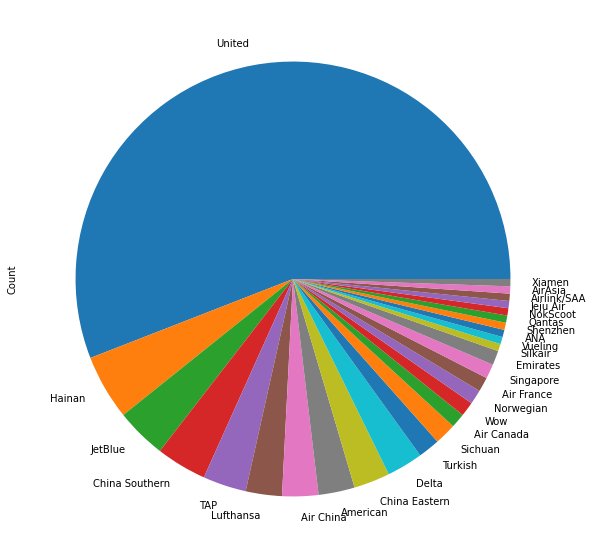

In [935]:
airlines.plot('Airline', 'Count', kind='pie', legend=False, figsize=(10, 10))

<AxesSubplot:ylabel='Total Distance'>

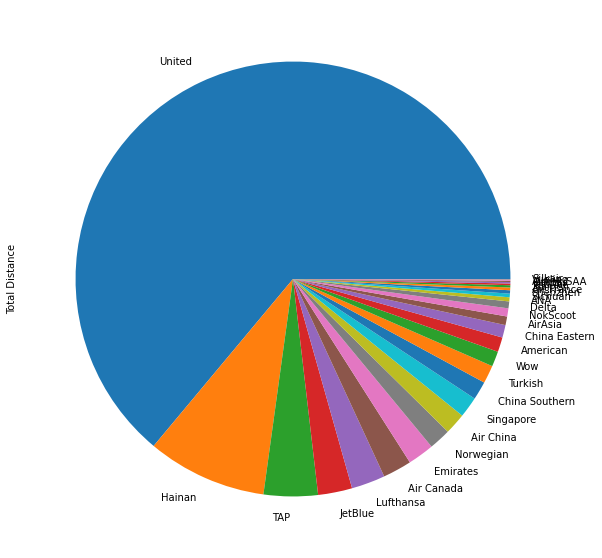

In [936]:
airlines.sort_values(by='Total Distance', ascending=False).plot('Airline', 'Total Distance', kind='pie', legend=False, figsize=(10, 10))

# TOP AIRCRAFT

In [937]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance']
aircraft

,Count,Total Distance
Aircraft,,
B738,29,36128.311019
A320,24,18475.536544
B772,23,137297.180470
B739,13,6209.745923
B789,11,47305.905249
A321,10,13611.998903
A319,10,7623.106557
B752,8,20533.794475
B788,7,36454.091790


<AxesSubplot:ylabel='Count'>

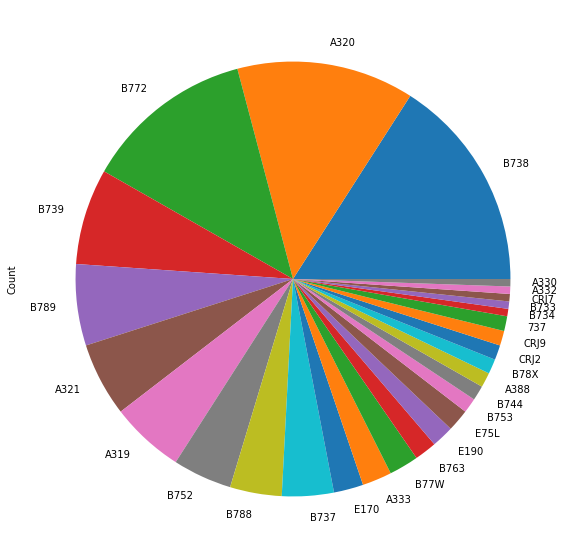

In [938]:
aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, figsize=(10, 10))

<AxesSubplot:ylabel='Total Distance'>

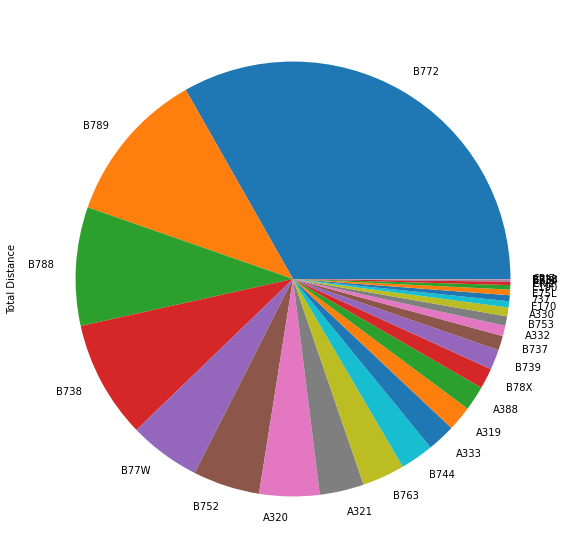

In [939]:
aircraft.sort_values(by='Total Distance', ascending=False).plot('Aircraft', 'Total Distance', kind='pie', legend=False, figsize=(10, 10))

# TOP AIRCRAFT REGS

In [940]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)
reg.columns = ['Count', 'Total Distance']
reg

,,Count,Total Distance
Registration,Aircraft,,
N78005,B772,3,20492.768472
N76010,B772,2,13661.845648
N19136,B752,2,5408.235630
N78008,B772,2,13661.845648
B7880,B789,2,1364.555397
N69020,B772,2,9249.750914
N33284,B738,2,1954.588769
N458UA,A320,2,846.738773
B2750,B788,2,14044.305986


# TOP + ALL GATES (MISSING A LOT OF DATA)

In [941]:
# df_orig = df.copy()
# df_switch = df.copy()
# df_orig = df_orig[df_orig['Dep Gate'].notna()]
# df_switch = df_switch[df_switch['Arr Gate'].notna()]
# df['Gate'] = df['Dep Airport'].astype(str) + ' ' + df['Dep Gate'].astype(str)
# df_switch['Gate'] = df['Arr Airport'].astype(str) + ' ' + df['Arr Gate'].astype(str)
# df_dup = pd.concat([df_orig, df_switch])
# df_dup_grouped = df_dup.groupby(['Gate']).agg({'Date': 'count'}).sort_values(by='Date', ascending=False).head(40)
# df_dup_grouped.columns = ['Count']
# df_dup_grouped

In [942]:
# df_dup_grouped.reset_index().sort_values(by='Gate')

# TRAVEL BY YEAR

In [943]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Flights']
dist_year

,Distance,Flights
Date,,
2015,29436.434579,10
2016,58570.729684,22
2017,78048.415226,39
2018,77923.939884,26
2019,84244.238494,32
2020,48040.013756,30
2021,53917.835224,29


<AxesSubplot:xlabel='Date'>

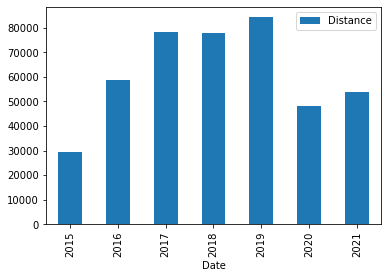

In [944]:
dist_year.reset_index().plot('Date', 'Distance', kind='bar')

<AxesSubplot:xlabel='Date'>

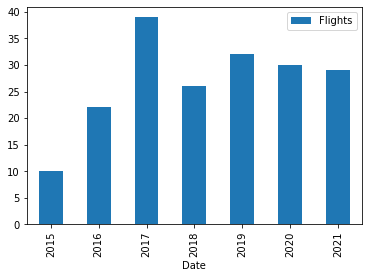

In [945]:
dist_year.reset_index().plot('Date', 'Flights', kind='bar')

# TRAVEL BY MONTH

In [946]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Flights']
dist_yearm.sort_values(by='Distance', ascending=False).head(30)

,,Distance,Flights
Date,Month,,
2019,12,20870.665731,7
2021,6,18558.120149,10
2016,3,17481.756684,8
2018,3,17028.219491,3
2019,8,15448.226232,3
2020,1,14596.349780,8
2017,10,14365.050635,4
2016,12,14231.539360,6
2015,3,14062.927086,4


<AxesSubplot:xlabel='Y-M'>

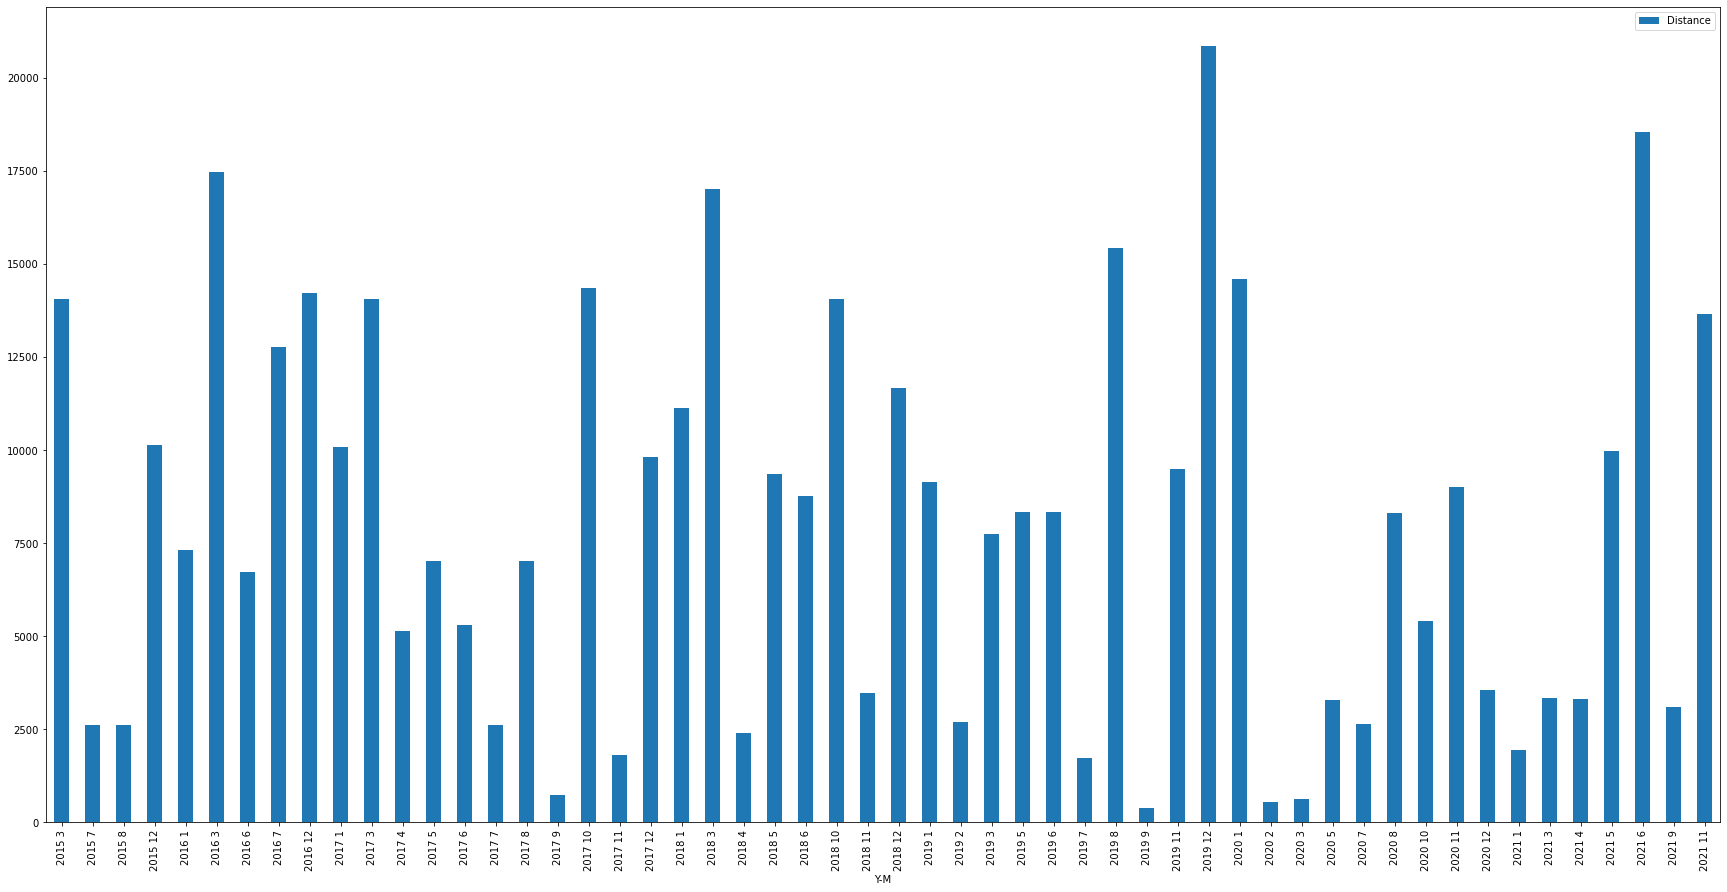

In [947]:
a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32')
a['Month'] = a['Month'].astype('int32')

a['Y-M'] = a['Date'].astype(str) + ' ' + a['Month'].astype(str)
a.plot('Y-M', 'Distance', kind='bar', figsize=(30, 15))

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [948]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

,Distance,Flights
Domestic/International,,
Domestic,124077.003233,119
International,306104.603614,69


In [949]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 1042.6638927114268
International average dist: 4436.298603103258


<AxesSubplot:ylabel='Distance'>

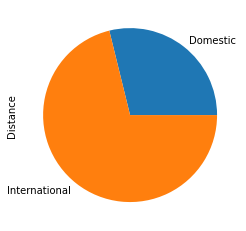

In [950]:
dom_int.plot('Domestic/International', 'Distance', kind='pie', legend=False)

<AxesSubplot:ylabel='Flights'>

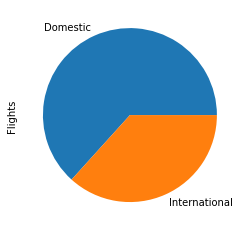

In [951]:
dom_int.plot('Domestic/International', 'Flights', kind='pie', legend=False)

In [952]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int

Distance  Flights
Date Domestic/International                       
2015 Domestic                 8943.666107        7
     International           20492.768472        3
2016 Domestic                11296.768030       13
     International           47273.961655        9
2017 Domestic                18719.510846       28
     International           59328.904380       11
2018 Domestic                 7371.939874       11
     International           70552.000010       15
2019 Domestic                16722.896473       17
     International           67521.342021       15
2020 Domestic                35641.590777       24
     International           12398.422979        6
2021 Domestic                25380.631125       19
     International           28537.204099       10

In [953]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

,Distance,Flights
Class,,
Business,150939.846045,48
Economy,273236.620792,136
Premium,2418.828090,1


# FARE CLASS BREAKDOWN

<AxesSubplot:ylabel='Distance'>

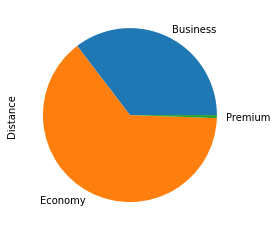

In [954]:
clas.plot('Class', 'Distance', kind='pie', legend=False)

<AxesSubplot:ylabel='Flights'>

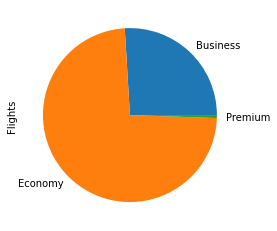

In [955]:
clas.plot('Class', 'Flights', kind='pie', legend=False)

In [956]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

Distance  Flights
Date Class                          
2015 Business    401.081439        2
     Economy   25915.573307        6
2016 Business  27053.538848        6
     Economy   31050.658750       15
2017 Business  26942.325389        7
     Economy   51106.089836       32
2018 Business  18262.603286        7
     Economy   59661.336598       19
2019 Business  38705.464773        9
     Economy   45538.773721       23
2020 Business  20535.636355       11
     Economy   27504.377401       19
2021 Business  19039.195954        6
     Economy   32459.811180       22
     Premium    2418.828090        1


# CLASS AND TRIP TYPE BREAKDOWN

In [957]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

Distance  Flights
Domestic/International Class                           
Domestic               Business   31027.279560       24
                       Economy    87044.583664       91
                       Premium     2418.828090        1
International          Business  119912.566486       24
                       Economy   186192.037128       45

<AxesSubplot:ylabel='Distance'>

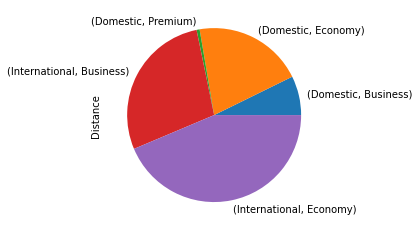

In [958]:
clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False)

<AxesSubplot:ylabel='Flights'>

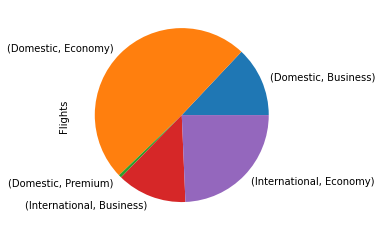

In [959]:
clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False)

# DEP, ARR TIMES, DELAYS

In [960]:
tf = TimezoneFinder()

def get_offset(t, lat, lng):
    """
    returns a location's time zone offset from UTC in hours.
    """
    tz_target = timezone(tf.certain_timezone_at(lng=lng, lat=lat))
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600

def get_offset_tz(t, tz_target):
    """
    returns a location's time zone offset from UTC in hours.
    """
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600


In [961]:
df_copy = df.copy()
ALL_TIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Scheduled Duration', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration']
DATETIME_COLS = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)']

# format the cols
for col in ALL_TIME_COLS:
    df_copy[col] = pd.to_datetime(df_copy[col]).dt.time
    if col in DATETIME_COLS:
        temp_col = df_copy['Date'].astype(str)+' '+df_copy[col].astype(str)
        temp_col = temp_col.replace('.*NaT', '', regex=True)
        df_copy[col] = pd.to_datetime(temp_col)

# get timezones
df_copy['Dep Timezone'] = df_copy[['Dep Lat', 'Dep Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Dep Long'], lat=r['Dep Lat'])), axis=1)
df_copy['Arr Timezone'] = df_copy[['Arr Lat', 'Arr Long']].apply(lambda r: timezone(tf.certain_timezone_at(lng=r['Arr Long'], lat=r['Arr Lat'])), axis=1)

# fill in UTC
for col in DATETIME_COLS:
    new_col = col.split('(')[0] + '(UTC)'
    deparr = 'Dep' if 'Dep' in col else 'Arr'
    for i, r in df_copy.iterrows():
        if str(r[col]) != 'NaT':
            df_copy.loc[i, new_col] = r[col]-timedelta(hours=get_offset(datetime.datetime.strptime(r[col].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r[deparr + ' Lat'], r[deparr + ' Long']))
    
# get calculated flght times
for time_type in ['Scheduled', 'Actual']:
    df_copy[time_type + ' difference'] = df_copy[time_type + ' Arr Time (UTC)'] - df_copy[time_type + ' Dep Time (UTC)']


# adjust dep/arr times, calculate delay
temp = pd.DataFrame()
for i, r in df_copy.iterrows():
    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' difference']) != 'NaT' and r[time_type + ' difference'].days < 0:
            r[time_type + ' Arr Time (UTC)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    if r['Flight'] == 'UA2360':
        print(dep_delay)
    if dep_delay.days < 0 and dep_delay.seconds < 86400-3600: # can't have actual dep more than 1 hour before scheduled
        r['Actual Dep Time (UTC)'] = r['Actual Dep Time (UTC)'] + timedelta(days=1)
        r['Actual Arr Time (UTC)'] = r['Actual Arr Time (UTC)'] + timedelta(days=1)
    dep_delay = r['Actual Dep Time (UTC)'] - r['Scheduled Dep Time (UTC)']
    arr_delay = r['Actual Arr Time (UTC)'] - r['Scheduled Arr Time (UTC)']
    r['Dep Delay'] = np.nan if str(dep_delay) == 'NaT' else dep_delay.seconds//60 if dep_delay.days >= 0 else dep_delay.seconds//60-1440
    r['Arr Delay'] = np.nan if str(arr_delay) == 'NaT' else arr_delay.seconds//60 if arr_delay.days >= 0 else arr_delay.seconds//60-1440

    for time_type in ['Scheduled', 'Actual']:
        if str(r[time_type + ' Dep Time (Local)']) != 'NaT':
            r[time_type + ' Dep Time (Local)'] = r[time_type + ' Dep Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Dep Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Dep Timezone']))
        if str(r[time_type + ' Arr Time (Local)']) != 'NaT':    
            r[time_type + ' Arr Time (Local)'] = r[time_type + ' Arr Time (UTC)'] + timedelta(hours=get_offset_tz(datetime.datetime.strptime(r[time_type + ' Arr Time (Local)'].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), r['Arr Timezone']))
   
    temp = temp.append(r)
    
    
df_copy = temp

-1 days +00:55:00


In [962]:
df_copy

,Actual Arr Time (Local),Actual Arr Time (UTC),Actual Dep Time (Local),Actual Dep Time (UTC),Actual Duration,Actual difference,Aircraft,Airline,Arr Airport,Arr City,Arr Connect,Arr Country,Arr Delay,Arr Lat,Arr Long,Arr Name,Arr Timezone,Business Type,Class,Date,Dep Airport,Dep City,Dep Country,Dep Delay,Dep Lat,Dep Long,Dep Name,Dep Timezone,Distance,Domestic/International,Duration,Flight,Layout,Month,Registration,Scheduled Arr Time (Local),Scheduled Arr Time (UTC),Scheduled Dep Time (Local),Scheduled Dep Time (UTC),Scheduled Duration,Scheduled difference,Seat,Sorted Route,Timing Data
0,2015-03-08 09:42:00,2015-03-08 13:42:00,2015-03-08 08:52:00,2015-03-08 12:52:00,00:50:00,0 days 00:50:00,B738,United,EWR,Newark,1.0,United States,-19.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,Recliner,Business,2015-03-08,BOS,Boston,United States,18.0,42.364300,-71.005203,General Edward Lawrence Logan International Ai...,America/New_York,200.540719,Domestic,50.0,UA1711,NaN,2015-03-08,N54241,2015-03-08 10:01:00,2015-03-08 14:01:00,2015-03-08 08:34:00,2015-03-08 12:34:00,01:27:00,0 days 01:27:00,NaN,BOS EWR,FlightStats
1,2015-03-09 15:10:00,2015-03-09 07:10:00,2015-03-08 13:40:00,2015-03-08 17:40:00,13:30:00,-1 days +13:30:00,B772,United,PEK,Beijing,NaN,China,10.0,40.080101,116.584999,Beijing Capital International Airport,Asia/Shanghai,NaN,Economy,2015-03-08,EWR,Newark,United States,45.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,6830.922824,International,810.0,UA89,NaN,2015-03-08,N78005,2015-03-09 15:00:00,2015-03-09 07:00:00,2015-03-08 12:55:00,2015-03-08 16:55:00,14:05:00,-1 days +14:05:00,NaN,EWR PEK,FlightStats
2,2015-03-19 18:15:00,2015-03-19 22:15:00,2015-03-19 17:24:00,2015-03-19 09:24:00,12:51:00,0 days 12:51:00,B772,United,EWR,Newark,1.0,United States,-30.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,NaN,Economy,2015-03-19,PEK,Beijing,China,24.0,40.080101,116.584999,Beijing Capital International Airport,Asia/Shanghai,6830.922824,International,771.0,UA88,NaN,2015-03-19,N78005,2015-03-19 18:45:00,2015-03-19 22:45:00,2015-03-19 17:00:00,2015-03-19 09:00:00,13:45:00,0 days 13:45:00,NaN,EWR PEK,FlightStats
3,2015-03-19 22:03:00,2015-03-20 02:03:00,2015-03-19 21:21:00,2015-03-20 01:21:00,00:42:00,0 days 00:42:00,B734,United,BOS,Boston,NaN,United States,17.0,42.364300,-71.005203,General Edward Lawrence Logan International Ai...,America/New_York,NaN,Economy,2015-03-19,EWR,Newark,United States,49.0,40.692501,-74.168701,Newark Liberty International Airport,America/New_York,200.540719,Domestic,42.0,UA1409,NaN,2015-03-19,N87512,2015-03-19 21:46:00,2015-03-20 01:46:00,2015-03-19 20:32:00,2015-03-20 00:32:00,01:14:00,0 days 01:14:00,NaN,BOS EWR,FlightStats
4,2015-07-05 20:30:00,2015-07-06 03:30:00,2015-07-05 18:00:00,2015-07-05 22:00:00,05:30:00,0 days 05:30:00,A320,JetBlue,LAX,Los Angeles,NaN,United States,-15.0,33.942501,-118.407997,Los Angeles International Airport,America/Los_Angeles,NaN,Economy,2015-07-05,BOS,Boston,United States,33.0,42.364300,-71.005203,General Edward Lawrence Logan International Ai...,America/New_York,2611.132058,Domestic,330.0,B6487,NaN,2015-07-05,N775JB,2015-07-05 20:45:00,2015-07-06 03:45:00,2015-07-05 17:27:00,2015-07-05 21:27:00,06:18:00,0 days 06:18:00,20E,BOS LAX,FlightStats
5,2015-08-01 19:59:00,2015-08-01 23:59:00,2015-08-01 12:10:00,2015-08-01 19:10:00,04:49:00,0 days 04:49:00,A320,JetBlue,BOS,Boston,NaN,United States,-6.0,42.364300,-71.005203,General Edward Lawrence Logan International Ai...,America/New_York,NaN,Economy,2015-08-01,LAX,Los Angeles,United States,35.0,33.942501,-118.407997,Los Angeles International Airport,America/Los_Angeles,2611.132058,Domestic,289.0,B6488,NaN,2015-08-01,N590JB,2015-08-01 20:05:00,2015-08-02 00:05:00,2015-08-01 11:35:00,2015-08-01 18:35:00,05:30:00,0 days 05:30:00,15E,BOS LAX,FlightStats
6,2015-12-18 09:29:00,2015-12-18 14:29:00,2015-12-18 08:35:00,2015-12-18 13:35:00,00:54:00,0 days 00

Early arrivals: 132 70%
On time arrivals (within 15 min): 27 14%
Late arrivals: 17 9%
Really late arrivals (1+hour): 6 3%


<AxesSubplot:ylabel='Frequency'>

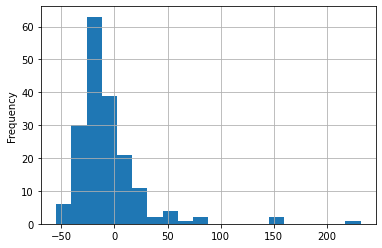

In [963]:
early_arrivals = df_copy[df_copy['Arr Delay'] < 0].shape[0]
on_time_arrivals = df_copy[(df_copy['Arr Delay'] >= 0) & (df_copy['Arr Delay'] < 15)].shape[0]
late_arrivals = df_copy[(df_copy['Arr Delay'] >= 15) & (df_copy['Arr Delay'] < 60)].shape[0]
really_late_arrivals = df_copy[df_copy['Arr Delay'] >= 60].shape[0]


print('Early arrivals:', early_arrivals, str(round(100*early_arrivals/NUM_FLIGHTS))+'%')
print('On time arrivals (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%')
print('Late arrivals:', late_arrivals, str(round(100*late_arrivals/NUM_FLIGHTS))+'%')
print('Really late arrivals (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%')



df_copy['Arr Delay'].plot.hist(bins=20, grid=True)

Early departures: 2 1%
On time departures (within 15 min): 68 36%
Late departures: 101 54%
Really late departures (1+hour): 11 6%


<AxesSubplot:ylabel='Frequency'>

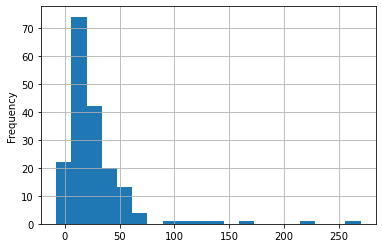

In [964]:
early_arrivals = df_copy[df_copy['Dep Delay'] < 0].shape[0]
on_time_arrivals = df_copy[(df_copy['Dep Delay'] >= 0) & (df_copy['Dep Delay'] < 15)].shape[0]
late_arrivals = df_copy[(df_copy['Dep Delay'] >= 15) & (df_copy['Dep Delay'] < 60)].shape[0]
really_late_arrivals = df_copy[df_copy['Dep Delay'] >= 60].shape[0]

print('Early departures:', early_arrivals, str(round(100*early_arrivals/NUM_FLIGHTS))+'%')
print('On time departures (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%')
print('Late departures:', late_arrivals, str(round(100*late_arrivals/NUM_FLIGHTS))+'%')
print('Really late departures (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%')



df_copy['Dep Delay'].plot.hist(bins=20, grid=True)

# ROUTES

In [965]:
import pyproj
from geojson import LineString, Feature, FeatureCollection, dump
import geopy.distance


def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Duration', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped




def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Duration'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)



# AIRPORTS AUGMENTED

In [966]:
from geojson import Point, Feature, FeatureCollection, dump

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    year_airports_aug.append(airports_aug)
    return airports_aug

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)


In [967]:
#### MAKE ROUTES
year_airports_aug = [] # first one is all

make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


/Users/alexanderguo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-965-373e90645454>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-965-373e90645454>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

<ipython-input-966-3449acb59ab2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
<ipython-input-966-3449acb59ab2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
<ipython-input-966-3449acb59ab2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

<ipython-input-966-3449acb59ab2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
<ipython-input-966-3449acb59ab2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
<ipython-input-966-3449acb59ab2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

<ipython-input-966-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-966-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-966-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<ipython-input-966-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-966-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-966-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<ipython-input-966-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-966-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-966-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

years done
2015
   3
   4
   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6
   7
   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10
   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12
2016
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2
   3
   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10
   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12
2017
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2018
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2019
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020 not in dep
   12


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2021
   1


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-967-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


# PRINTING

In [968]:
def get_stats(df, airports_aug, year=None, a=False):
    TOTAL_DIST = df['Distance'].sum()
    TOTAL_TIME = df['Duration'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count'})
    dist_year.columns = ['Distance', 'Flights']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
    dom_int.columns = ['Distance', 'Flights']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
    clas.columns = ['Distance', 'Flights']
    
    big_str = ''
    if a:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + str(int(round(TOTAL_DIST))) + '</span>mi' + '\n'
    big_str += '<p>Total Time in Air: <span class=\'bold\'>' + str(timedelta(minutes=int(TOTAL_TIME))) + '</span>' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'

    def get_time(minutes):
        return [minutes//60, minutes % 60]

    def get_time_str(minutes):
        if get_time(minutes)[0] == 0:
            return str(get_time(minutes)[1]) + 'min'
        else:
            return str(get_time(minutes)[0]) + 'h ' + str(get_time(minutes)[1]) + 'm'
        
    def get_distance(distance):
        dist_str = str(int(round(distance)))
        if len(dist_str) > 3:
            new_dist_str = ''
            for i in range(len(dist_str)-3, 0, -3):
                new_dist_str += dist_str[i:i+3][::-1] + ','
            new_dist_str += dist_str[:i][::-1]
            return new_dist_str[::-1]
        else:
            return dist_str

    by_dist = df.sort_values(by='Distance')
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + get_distance(by_dist.iloc[0]['Distance']) + 'mi, ' + get_time_str(by_dist.iloc[0]['Duration']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Distance', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + get_distance(by_dist2.iloc[0]['Distance']) + 'mi, ' + get_time_str(by_dist2.iloc[0]['Duration']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:3]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<p>Airports by total visits: '
    for airport, total in visited_list[:3]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2] + '</p>'
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<p>Top routes: '
    for route, count in routes_list[:3]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2] + '</p>'
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<p>Top airlines: '
    for airline, count in airlines_list[:3]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2] + '</p>'
    big_str += top_airlines + '\n'

    if a: # ind years don't need this
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights']].values.tolist()
        years = '<P>'
        for year, dist, count in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + get_distance(dist) + 'mi, ' + str(int(count)) + ' flights, '
        years = years[:-2] + '</p>'
        big_str += years + '\n'

    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + get_distance(dist) + 'mi, ' + str(int(count)) + ' flights, '
    domint = domint[:-2] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + get_distance(dist) + 'mi, ' + str(int(count)) + ' flights, '
    class_str = class_str[:-2] + '</p>'
    big_str += class_str + '\n'
    
    return big_str

big_str = get_stats(df, year_airports_aug[0], a=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[i+1], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)

In [969]:
big_str

"<h2><span class='bold'>Alex's Flight Log (2021)</span></h2><p>Total Distance Flown: <span class='bold'>53918</span>mi\n<p>Total Time in Air: <span class='bold'>3 days, 13:33:00</span>\n<br>Total Flights: <span class='bold'>29</span>\n<br>Number of Airlines: <span class='bold'>5</span>, Countries: <span class='bold'>9</span>, Airports: <span class='bold'>17</span>\n<p>Shortest flight: <span class='bold'>EWR</span> to <span class='bold'>BOS</span> (201mi, 1h 5m)\n<br>Longest flight: <span class='bold'>LIS</span> to <span class='bold'>SFO</span> (5,681mi, 0min)</p>\n<p>Airport distribution (top countries): <span class='bold'>United States</span>: 8, <span class='bold'>Turkey</span>: 2, <span class='bold'>Germany</span>: 1\n<p>Airports by total visits: <span class='bold'>BOS</span>: 10, <span class='bold'>EWR</span>: 5, <span class='bold'>SFO</span>: 5</p>\n<p>Top routes: <span class='bold'>BOS</span> to <span class='bold'>EWR</span>: 4, <span class='bold'>BOS</span> to <span class='bold'